# Using the Steam API Scraper

Honestly the hardest part for me for this whole project (was probably too ambitious), but I wanted to use Steam reviews as a baseline to see if a model can see if it's a positive or a negative review

The idea here is to use a Steam API Scraper from this github post (https://github.com/israel-dryer/Steam-Game-Review-Scraper) for 5 different games, combine the datasets into one big dataframe, clean the data up, and then train the model using this data.

The code doesn't really show the steps for each individual, but all of these steps were used to eventually get the 5 .csv's in the dataset folder one by one.

Installing Chrome in the Colab VM

In [ ]:
!apt update
!apt install -y wget unzip
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb || apt -fy install

!apt-get update
!apt install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
!pip install undetected-chromedriver selenium


Installing Selenium and verifying

In [ ]:
!pip install -q selenium

In [ ]:
pip show selenium

Verifying that colab has OpenPYXL to save data to an Excel Spreadsheet

In [ ]:
pip show openpyxl

Installing Chrome Driver to make this work better inside a notebook

In [ ]:
!pip install webdriver-manager


import tools

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.keys import Keys
import re
from time import sleep
from datetime import datetime
from openpyxl import Workbook
import csv

import undetected_chromedriver as uc
from selenium.webdriver.common.by import By



In [ ]:
# Launch undetected Chrome
options = uc.ChromeOptions()
options.headless = True
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = uc.Chrome(options=options)

Lookup game id on steam with the applied filters

In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# cs2 (730)
# binding of isaac (250900)
# mhwilds (2246340)
# battlefield 2042 (1517290)
# stardew valley (413150)

game_id = 413150
review_type = 'negative'

url_template = 'https://steamcommunity.com/app/{}/{}reviews/?browsefilter=trendyear&p=1'

url = url_template.format(game_id, review_type)

driver.maximize_window()
driver.get(url)

print(url)


https://steamcommunity.com/app/413150/negativereviews/?browsefilter=trendyear&p=1


Time to scrape data

In [ ]:
# get current position of y scrollbar
last_position = driver.execute_script("return window.pageYOffset;")

reviews = []
review_ids = set()
running = True

while len(reviews) < 501:
    # get cards on the page
    cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

    for card in cards[-20:]:  # only the tail end are new cards

        # gamer profile url
        profile_url = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')

        # steam id
        steam_id = profile_url.split('/')[-2]

        # check to see if I've already collected this review
        if steam_id in review_ids:
            continue
        else:
            review_ids.add(steam_id)

        # username
        user_name = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').text

        # language of the review
        date_posted = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div').text
        review_content = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]').text.replace(date_posted,'').strip()

        # review length
        review_length = len(review_content.replace(' ', ''))

        # recommendation
        thumb_text = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[2]').text

        # amount of play hours
        play_hours = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[3]').text

        # save review
        review = (steam_id, profile_url, review_content, thumb_text, review_length, play_hours, date_posted)
        reviews.append(review)

    # attempt to scroll down thrice.. then break
    scroll_attempt = 0
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        sleep(0.5)
        curr_position = driver.execute_script("return window.pageYOffset;")

        if curr_position == last_position:
            scroll_attempt += 1
            sleep(0.5)

            if scroll_attempt >= 3:
                running = False
                break
        else:
            last_position = curr_position
            break  # continue scraping the results

# shutdown the web driver
driver.close()


Saving the results to a Excel Spreadsheet

In [ ]:
# save the file to Excel Worksheet
wb = Workbook()
ws = wb.worksheets[0]
ws.append(['SteamId', 'ProfileURL', 'ReviewText', 'Review', 'ReviewLength(Chars)', 'PlayHours', 'DatePosted'])
for row in reviews:
    ws.append(row)

today = datetime.today().strftime('%Y%m%d')
wb.save(f'Steam_Reviews_{game_id}_{today}.xlsx')
wb.close()


In [ ]:
# save the file to a CSV file
today = datetime.today().strftime('%Y%m%d')
with open(f'Steam_Reviews_{game_id}_{today}.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['SteamId', 'ProfileURL', 'ReviewText', 'Review', 'ReviewLength(Chars)', 'PlayHours', 'DatePosted'])
    writer.writerows(reviews)


# Training the models

Preprocessing Text Data in .csv with tokenization, stop-word removal, and lemmatization via script

Import and load spreadsheet

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [58]:
# Load spreadsheet
df_cs2 = pd.read_csv('CS2.csv')
df_bf = pd.read_csv('Battlefield 2042.csv')
df_boi = pd.read_csv('Binding of Isaac Rebirth.csv')
df_mhwilds = pd.read_csv('MHWilds.csv')
df_sdv = pd.read_csv('Stardew Valley.csv')

# Set up preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Define the text cleaning function
def preprocess(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation and numbers
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # lemmatize
    # return tokens;
    return " ".join(tokens)

# Making my life easier for merging multiple .csv's
def clean_df(df, text_col="ReviewText", label_col="Review"):
    # Applying the preprocessing
    df["text"] = df[text_col].apply(preprocess)
    # Label Recommended or Not Recommended as 1 or -1 respectively in a new "Ratings" Column
    # Not Recommended = 0
    # Recommended = 1
    df["label"] = df[label_col].replace({
        "Recommended": 1,
        "Not Recommended": 0
    })
    return df[["text", "label"]]

# cleaning up all the .csv's and combining them into one dataframe
df_cs2_clean = clean_df(df_cs2)
df_bf_clean = clean_df(df_bf)
df_boi_clean = clean_df(df_boi)
df_mhwilds_clean = clean_df(df_mhwilds)
df_sdv_clean = clean_df(df_sdv)

df = pd.concat([df_cs2_clean, df_bf_clean, df_boi_clean, df_mhwilds_clean, df_sdv_clean], ignore_index=True)

df[["text", "label"]] # The columns I'll be focusing on for sentimental analysis

<ipython-input-58-77574a921d4e>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df[label_col].replace({
<ipython-input-58-77574a921d4e>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df[label_col].replace({
<ipython-input-58-77574a921d4e>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downc

,text,label
0,youll find less cheater tinder,0
1,saddens billion dollar revenue game doesnt pro...,0
2,year passed armory update cash grab real gamep...,0
3,terrible anti cheat people getting false ban h...,0
4,semi rage cheater wallhackers detected valve s...,0
...,...,...
4995,game comfort game wife many year mod community...,1
4996,sinistro,1
4997,mum really like game,1
4998,,1


Visualizing word frequencies to make sure no outliers will bother the data

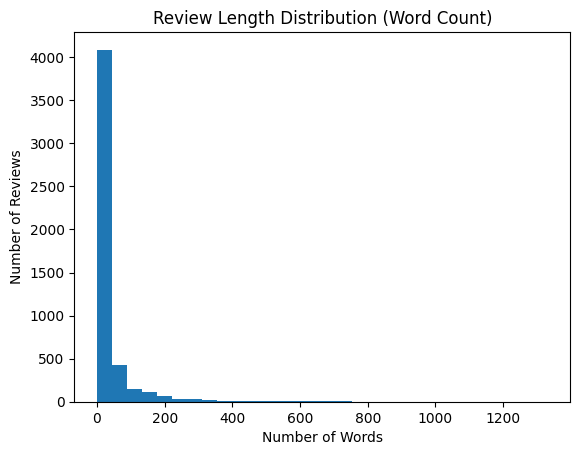



Number of unique words: 14833




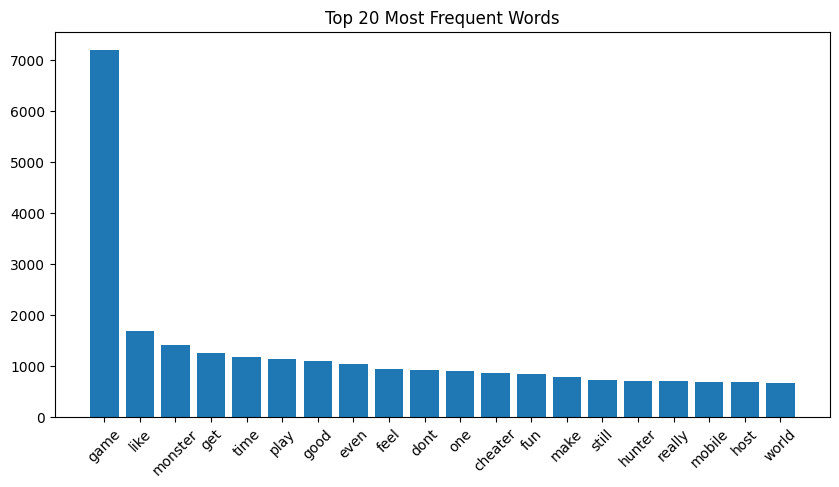

In [59]:
from collections import Counter
import matplotlib.pyplot as plt

#Class distribution: check how many texts belong to each class
#  Text length: analyze the distribution of text lengths (number of words, characters).
#  Word count: calculate the total number of unique words across the corpus.
#  Most common words: find frequent words across all texts, which can give insights into the vocabulary.
#  Visualization:
#      Bar plots of top N words: Useful to show the most frequent words across the dataset.


# Flatten all text into a single list and count frequencies
all_text = [word for tokens in df['text'] for word in tokens.split()]
text_counts = Counter(all_text)

#  Text length: analyze the distribution of text lengths (number of words, characters).
# We do this by plotting the distribution of number of words per review


# Calculate word frequency per document
word_freq_per_doc = [len(tokens.split()) for tokens in df['text']]

plt.hist(word_freq_per_doc, bins=30)
plt.title("Review Length Distribution (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()



# Number of unique words
#  Word count: calculate the total number of unique words across the corpus.
num_unique_words = len(set(all_text))
print(f"\n\nNumber of unique words: {num_unique_words}\n\n")

# Plot the most common words
#  Most common words: find frequent words across all texts, which can give insights into the vocabulary.
common_words = text_counts.most_common(20)
words, counts = zip(*common_words)

# Displaying in graph
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()




Transforming the text data using TF-IDF then splitting into Training/Test Sets

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# TF-IDF extraction
vectorizer = TfidfVectorizer()  # Use CountVectorizer() for BoW

# Fit and transform the text data
X = vectorizer.fit_transform(df['text'])
y = df["label"]


from sklearn.model_selection import train_test_split

# splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=30
)

# Print the shapes of the splits to check if the splits were successful
print(f"Training set features (x_train): {X_train.shape}")
print(f"Test set features (x_test): {X_test.shape}")
print(f"Training set target (y_train): {y_train.shape}")
print(f"Test set target (y_test): {y_test.shape}")

Training set features (x_train): (4000, 14810)
Test set features (x_test): (1000, 14810)
Training set target (y_train): (4000,)
Test set target (y_test): (1000,)


LogisticRegression Model

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Accuracy scores
lr_train_accuracy = accuracy_score(y_train, y_pred_lr_train)
lr_test_accuracy = accuracy_score(y_test, y_pred_lr_test)

# Print formatted output
print("Logistic Regression\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(lr_train_accuracy, lr_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lr_test))


Logistic Regression	 Train Accuracy: 0.88650	 Test Accuracy: 0.75800
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       500
           1       0.75      0.78      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



LinearSVC (Linear Support Vector Classification) Model

In [62]:
from sklearn.svm import LinearSVC

# LinearSVC
lsvc_model = LinearSVC()
lsvc_model.fit(X_train, y_train)

# Predictions
y_pred_lsvc_train = lsvc_model.predict(X_train)
y_pred_lsvc_test = lsvc_model.predict(X_test)

# Accuracy scores
lsvc_train_accuracy = accuracy_score(y_train, y_pred_lsvc_train)
lsvc_test_accuracy = accuracy_score(y_test, y_pred_lsvc_test)

# Print formatted output
print("Linear SVC\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(lsvc_train_accuracy, lsvc_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lsvc_test))


Linear SVC	 Train Accuracy: 0.95550	 Test Accuracy: 0.73800
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.71      0.73       500
           1       0.73      0.76      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



SGDClassifier (Stochastic Gradient Descent) Model

In [63]:
from sklearn.linear_model import SGDClassifier

# SGDClassifier
sgdc_model = SGDClassifier(loss='hinge', max_iter=1000, random_state=30)
sgdc_model.fit(X_train, y_train)

# Predictions
y_pred_sgdc_train = sgdc_model.predict(X_train)
y_pred_sgdc_test = sgdc_model.predict(X_test)

# Accuracy scores
sgdc_train_accuracy = accuracy_score(y_train, y_pred_sgdc_train)
sgdc_test_accuracy = accuracy_score(y_test, y_pred_sgdc_test)

# Print formatted output
print("SGDC Classifier\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(sgdc_train_accuracy, sgdc_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_sgdc_test))


SGDC Classifier	 Train Accuracy: 0.94575	 Test Accuracy: 0.72400
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71       500
           1       0.71      0.76      0.73       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



Naive Bayes - MultinomialNB Model

In [64]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)

# Predictions
y_pred_mnb_train = mnb_model.predict(X_train)
y_pred_mnb_test = mnb_model.predict(X_test)

# Accuracy scores
mnb_train_accuracy = accuracy_score(y_train, y_pred_mnb_train)
mnb_test_accuracy = accuracy_score(y_test, y_pred_mnb_test)

# Print formatted output
print("Naive Bayes Classifier\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(mnb_train_accuracy, mnb_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_mnb_test))


Naive Bayes Classifier	 Train Accuracy: 0.88700	 Test Accuracy: 0.74000
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       500
           1       0.76      0.70      0.73       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



Total Outputs

In [65]:
# Print formatted output
print("{:<30} {:<20} {:<20}".format("Model", "Train Accuracy", "Test Accuracy"))
print("-" * 70)

print("{:<30} {:.5f} {:>20.5f}".format("Logistic Regression", lr_train_accuracy, lr_test_accuracy))
print("{:<30} {:.5f} {:>20.5f}".format("Linear SVC", lsvc_train_accuracy, lsvc_test_accuracy))
print("{:<30} {:.5f} {:>20.5f}".format("SGD Classifier", sgdc_train_accuracy, sgdc_test_accuracy))
print("{:<30} {:.5f} {:>20.5f}".format("Naive Bayes", mnb_train_accuracy, mnb_test_accuracy))


Model                          Train Accuracy       Test Accuracy       
----------------------------------------------------------------------
Logistic Regression            0.88650              0.75800
Linear SVC                     0.95550              0.73800
SGD Classifier                 0.94575              0.72400
Naive Bayes                    0.88700              0.74000


Tuning the hyperparameters of each classifiers to their optimal value using GridSearch

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
#hyperparameter testing
print('Testing for hyperparameters:')
print('---------------------------------------------------------')

#logistic regression
from sklearn.linear_model import LogisticRegression

lr_param = {
    'solver': ('lbfgs', 'liblinear', 'newton-cg'),
    'max_iter': (500, 750, 1000, 1250)
}

gs_lr = GridSearchCV(lr_model, lr_param, cv=5, n_jobs=-1)
gs_lr = gs_lr.fit(X_train, y_train)
print('Logistic Regression:')
for param_name in sorted(lr_param.keys()):
    print("%s: %r" % (param_name, gs_lr.best_params_[param_name]))
print('---------------------------------------------------------')

# Logistic Regression
lr_model = LogisticRegression(max_iter=500, solver='newton-cg')
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Accuracy scores
lr_train_accuracy = accuracy_score(y_train, y_pred_lr_train)
lr_test_accuracy = accuracy_score(y_test, y_pred_lr_test)

# Print formatted output
print("Logistic Regression\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(lr_train_accuracy, lr_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lr_test))
print('---------------------------------------------------------')



from sklearn.svm import LinearSVC

#LinearSVC
lsvc_param = {
    'max_iter': (500, 750, 1000, 2000, 2500),
    'C': (0.01, 0.1, 0.5, 1.0, 1.5),
}

gs_lsvc = GridSearchCV(lsvc_model, lsvc_param, cv=5, n_jobs=-1)
gs_lsvc = gs_lsvc.fit(X_train, y_train)
print('LinearSVC:')
for param_name in sorted(lsvc_param.keys()):
    print("%s: %r" % (param_name, gs_lsvc.best_params_[param_name]))
print('---------------------------------------------------------')


# LinearSVC
lsvc_model = LinearSVC(C=0.1, max_iter=500)
lsvc_model.fit(X_train, y_train)

# Predictions
y_pred_lsvc_train = lsvc_model.predict(X_train)
y_pred_lsvc_test = lsvc_model.predict(X_test)

# Accuracy scores
lsvc_train_accuracy = accuracy_score(y_train, y_pred_lsvc_train)
lsvc_test_accuracy = accuracy_score(y_test, y_pred_lsvc_test)

# Print formatted output
print("Linear SVC\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(lsvc_train_accuracy, lsvc_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_lsvc_test))
print('---------------------------------------------------------')

#SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_param = {
    'max_iter': (1500, 1000, 500),
    'loss': ('hinge', 'perceptron', 'squared_error'),
    'alpha': (0.01, 0.005, 0.001),
}

gs_sgdc = GridSearchCV(sgdc_model, sgd_param, cv=5, n_jobs=-1)
gs_sgdc = gs_sgdc.fit(X_train, y_train)
print('SGDClassifier:')
for param_name in sorted(sgd_param.keys()):
    print("%s: %r" % (param_name, gs_sgdc.best_params_[param_name]))
print('---------------------------------------------------------')
#  Testing the Hyperparameters for SGDC Classifier
sgdc_model = SGDClassifier(alpha=0.001, loss='squared_error', max_iter=1500, random_state=30)
sgdc_model.fit(X_train, y_train)

# Predictions
y_pred_sgdc_train = sgdc_model.predict(X_train)
y_pred_sgdc_test = sgdc_model.predict(X_test)

# Accuracy scores
sgdc_train_accuracy = accuracy_score(y_train, y_pred_sgdc_train)
sgdc_test_accuracy = accuracy_score(y_test, y_pred_sgdc_test)

# Print formatted output
print("SGDC Classifier\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(sgdc_train_accuracy, sgdc_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_sgdc_test))
print('---------------------------------------------------------')






#naive bayes
from sklearn.naive_bayes import MultinomialNB

mnb_param = {
    'fit_prior': (True, False),
    'force_alpha': (True, False),
    'alpha': (1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1),
}

gs_mnb = GridSearchCV(mnb_model, mnb_param, cv=5, n_jobs=-1)
gs_mnb = gs_mnb.fit(X_train, y_train)
print('Naive Bayes:')
for param_name in sorted(mnb_param.keys()):
    print("%s: %r" % (param_name, gs_mnb.best_params_[param_name]))
print('---------------------------------------------------------')

# Testing the Hyperparameters for Naive Bayes
mnb_model = MultinomialNB(alpha=0.8, fit_prior=True, force_alpha=True)
mnb_model.fit(X_train, y_train)

# Predictions
y_pred_mnb_train = mnb_model.predict(X_train)
y_pred_mnb_test = mnb_model.predict(X_test)

# Accuracy scores
mnb_train_accuracy = accuracy_score(y_train, y_pred_mnb_train)
mnb_test_accuracy = accuracy_score(y_test, y_pred_mnb_test)

# Print formatted output
print("Naive Bayes Classifier\t Train Accuracy: {:.5f}\t Test Accuracy: {:.5f}".format(mnb_train_accuracy, mnb_test_accuracy))

# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_mnb_test))

# Print formatted output
print("{:<30} {:<20} {:<20}".format("Model", "Train Accuracy", "Test Accuracy"))
print("-" * 70)

# Print new total train/test accuracies post hyperparameter tuning
print("{:<30} {:.5f} {:>20.5f}".format("Logistic Regression", lr_train_accuracy, lr_test_accuracy))
print("{:<30} {:.5f} {:>20.5f}".format("Linear SVC", lsvc_train_accuracy, lsvc_test_accuracy))
print("{:<30} {:.5f} {:>20.5f}".format("SGD Classifier", sgdc_train_accuracy, sgdc_test_accuracy))
print("{:<30} {:.5f} {:>20.5f}".format("Naive Bayes", mnb_train_accuracy, mnb_test_accuracy))


Testing for hyperparameters:
---------------------------------------------------------
Logistic Regression:
max_iter: 500
solver: 'newton-cg'
---------------------------------------------------------
Logistic Regression	 Train Accuracy: 0.88650	 Test Accuracy: 0.75800
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       500
           1       0.75      0.78      0.76       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

---------------------------------------------------------
LinearSVC:
C: 0.1
max_iter: 500
---------------------------------------------------------
Linear SVC	 Train Accuracy: 0.88325	 Test Accuracy: 0.75500
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       500
           1       0.74      0.78      

# Deep Learning Network with Transformer

Importing necessary libraries for the Deep Learning Network

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset # Used implicitly by Hugging Face Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    PreTrainedModel # Type hinting for return
)
!pip install datasets
from datasets import Dataset as HFDataset # Import Hugging Face's Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import os
import sys

Code from Vincent

In [ ]:
# Models/sentiment_trainer_function.py
# Tokenization Function for map()
def tokenize_function(examples, tokenizer, max_len):
    """Applies tokenizer to examples in a batch."""
    return tokenizer(
        examples["text"],
        padding="max_length", # Pad to max_length
        truncation=True,      # Truncate if longer than max_length
        max_length=max_len,
    )

# Define Metrics Calculation
def compute_metrics(eval_pred):
    """Computes classification metrics from predictions."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Use 'binary' average for 2-class problems
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


# --- Training Function ---

def train_amazon_sentiment_transformer(
    X_train_raw: pd.Series,
    X_val_raw: pd.Series,
    X_test_raw: pd.Series,
    y_train: pd.Series,
    y_val: pd.Series,
    y_test: pd.Series,
    model_name: str = 'bert-base-uncased',
    output_dir: str = './results_amazon_sentiment',
    num_train_epochs: int = 3,
    per_device_train_batch_size: int = 16,
    per_device_eval_batch_size: int = 16,
    max_len: int = 128,
):

    """
    Trains a Hugging Face Transformer for sentiment analysis on pre-split data
    and returns the trained model.

    Args:
        X_train_raw (pd.Series): Pandas Series containing raw training text reviews.
        X_val_raw (pd.Series): Pandas Series containing raw validation text reviews.
        X_test_raw (pd.Series): Pandas Series containing raw testing text reviews.
        y_train (pd.Series): Pandas Series containing training labels.
        y_val (pd.Series): Pandas Series containing validation labels.
        y_test (pd.Series): Pandas Series containing testing labels.
        model_name (str): Name of the pre-trained model from Hugging Face Hub.
        output_dir (str): Directory to save training checkpoints and results.
        num_train_epochs (int): Total number of training epochs.
        per_device_train_batch_size (int): Batch size per GPU/CPU for training.
        per_device_eval_batch_size (int): Batch size per GPU/CPU for evaluation.
        max_len (int): Maximum sequence length for tokenizer padding/truncation.
        # Add more args matching TrainingArguments parameters

    Returns:
        PreTrainedModel: The trained Hugging Face Transformer model.
    """
    print(f"\n--- Starting Transformer Training Process ---")
    print(f"Model: {model_name}, Output Dir: {output_dir}, Epochs: {num_train_epochs}")
    print(f"Training data size: {len(X_train_raw)}")
    print(f"Validation data size: {len(X_val_raw)}")
    print(f"Testing data size: {len(X_test_raw)}")


    # Convert pandas Series to Hugging Face Dataset format
    print("\nCreating Hugging Face Datasets from splits...")
    train_dict = {'text': X_train_raw.tolist(), 'label': y_train.tolist()}
    val_dict = {'text': X_val_raw.tolist(), 'label': y_val.tolist()}
    test_dict = {'text': X_test_raw.tolist(), 'label': y_test.tolist()} # Keep test set as HF dataset too

    train_dataset = HFDataset.from_dict(train_dict)
    val_dataset = HFDataset.from_dict(val_dict)
    test_dataset = HFDataset.from_dict(test_dict)

    print("Hugging Face Datasets created.")


    # Initialize Tokenizer
    print(f"\nLoading tokenizer: {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)


    # Apply tokenization to datasets using map()
    print("Tokenizing datasets...")
    # Use lambda to pass tokenizer and max_len to tokenize_function
    tokenized_train_dataset = train_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )
    tokenized_val_dataset = val_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )
    tokenized_test_dataset = test_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )
    print("Tokenization complete.")


    # --- Model Loading ---
    print(f"\nLoading pre-trained model: {model_name} for sequence classification...")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    print("Model loaded.")

    # --- Training Arguments ---
    print("\nDefining Training Arguments...")
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,          # Output directory for checkpoints and results
        eval_strategy="epoch",          # Evaluate every epoch
        save_strategy="epoch",          # Save checkpoint every epoch
        save_total_limit=2,             # Limit the number of checkpoints to keep (e.g., keep last 2)
        num_train_epochs=num_train_epochs, # Total number of training epochs
        per_device_train_batch_size=per_device_train_batch_size, # Batch size per GPU/CPU for training
        per_device_eval_batch_size=per_device_eval_batch_size,  # Batch size per GPU/CPU for evaluation
        # Add other common arguments or make them function parameters
        learning_rate=2e-5,             # Default learning rate
        warmup_steps=500,               # Default warmup steps
        weight_decay=0.01,              # Default weight decay
        logging_dir=f'{output_dir}/logs',# Directory for storing logs
        logging_steps=10,               # Log every N update steps
        fp16=torch.cuda.is_available(), # Enable mixed precision training if CUDA is available
        load_best_model_at_end=True,    # Load the best model found during training at the end
        metric_for_best_model="accuracy", # Metric to monitor for best model saving
        greater_is_better=True,         # Whether the metric is better when greater
        report_to="none"                # Prevent reporting to external services by default
    )
    print("Training Arguments defined.")

    # --- Initialize the Trainer ---
    print("\nInitializing Trainer...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    print("Trainer initialized.")

    # --- Train the Model ---
    print("\n--- Starting Model Training ---")
    trainer.train()
    print("--- Training Complete ---")

    # --- Final Evaluation on Test Set ---
    print("\n--- Performing Final Evaluation on Test Set ---")
    # Evaluate on the test set that was held out
    test_results = trainer.evaluate(eval_dataset=tokenized_test_dataset)
    print(f"Transformer Test Results: {test_results}")
    print("--- Test Evaluation Complete ---")


    # Return the trained model (loaded with best weights if load_best_model_at_end=True)
    print("\nReturning the trained Transformer model.")
    return trainer.model

Creating new train and test data for the DLM

In [ ]:
# Fit and transform the text data
X_tf = df['text']
y_tf = df["label"]

# splitting into train and test data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    X_tf, y_tf, stratify=y_tf, test_size=0.2, random_state=30
)

# for the transformer
X_train_tf, X_val, y_train_tf, y_val = train_test_split(
    X_train_tf, y_train_tf, stratify=y_train_tf, test_size=0.2, random_state=30
)

transformer_params = {
            'X_train_raw': X_train_tf,
            'X_val_raw': X_val,
            'X_test_raw': X_test_tf,
            'y_train': y_train_tf,
            'y_val': y_val,
            'y_test': y_test_tf,
            'model_name': 'distilbert-base-uncased'
            # Add more parameters if needed
        }

Saving the model for myself to load in

In [ ]:
# Save the trained model
transformer_model_path = "/content/"  # Specify a path to save the model
# transformer_model.save_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.save_pretrained(transformer_model_path)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the path where the model is saved
model_path = "/content/SteamReviewsDLN"

# Load the saved model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer (this is important for proper tokenization)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Method to load a pre-trained model for evaluation

In [ ]:
def test_amazon_sentiment_transformer(X_train, X_val, y_train, y_val, model, tokenizer):
    max_len: int = 128

    training_args = TrainingArguments(
            output_dir='./results_amazon_sentiment',          # Output directory for checkpoints and results
            eval_strategy="epoch",          # Evaluate every epoch
            save_strategy="epoch",          # Save checkpoint every epoch
            save_total_limit=2,             # Limit the number of checkpoints to keep (e.g., keep last 2)
            num_train_epochs= 3,  # Total number of training epochs
            per_device_train_batch_size= 16, # Batch size per GPU/CPU for training
            per_device_eval_batch_size= 16,  # Batch size per GPU/CPU for evaluation
            # Add other common arguments or make them function parameters
            learning_rate=2e-5,             # Default learning rate
            warmup_steps=500,               # Default warmup steps
            weight_decay=0.01,              # Default weight decay
            logging_dir=f'content/logs',# Directory for storing logs
            logging_steps=10,               # Log every N update steps
            fp16=torch.cuda.is_available(), # Enable mixed precision training if CUDA is available
            load_best_model_at_end=True,    # Load the best model found during training at the end
            metric_for_best_model="accuracy", # Metric to monitor for best model saving
            greater_is_better=True,         # Whether the metric is better when greater
            report_to="none"                # Prevent reporting to external services by default
        )
    print("Training Arguments defined.")

    def tokenize_function(examples, tokenizer, max_len):
      """Applies tokenizer to examples in a batch."""
      return tokenizer(
          examples["text"],
          padding="max_length", # Pad to max_length
          truncation=True,      # Truncate if longer than max_length
          max_length=max_len,
    )

    # Define Metrics Calculation
    def compute_metrics(eval_pred):
        """Computes classification metrics from predictions."""
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        # Use 'binary' average for 2-class problems
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
        acc = accuracy_score(labels, predictions)
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }


    # defining dict and datasets
    train_dict = {'text': X_train.tolist(), 'label': y_train.tolist()}
    val_dict = {'text': X_val.tolist(), 'label': y_val.tolist()}

    train_dataset = HFDataset.from_dict(train_dict)
    val_dataset = HFDataset.from_dict(val_dict)

    tokenized_train_dataset = train_dataset.map(
    lambda examples: tokenize_function(examples, tokenizer, max_len),
    batched=True,
    remove_columns=["text"]
    )
    tokenized_val_dataset = val_dataset.map(
        lambda examples: tokenize_function(examples, tokenizer, max_len),
        batched=True,
        remove_columns=["text"] # Remove original text column
    )

    # --- Initialize the Trainer ---
    print("\nInitializing Trainer...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    print("Trainer initialized.")

    # --- Final Evaluation on Test Set ---
    print("\n--- Performing Final Evaluation on Test Set ---")
    # Evaluate on the test set that was held out
    test_results = trainer.evaluate(eval_dataset=tokenized_val_dataset)
    print("\n--- Transformer Test Results ---")
    print(f"Loss:       {test_results['eval_loss']:.4f}")
    print(f"Accuracy:   {test_results['eval_accuracy']:.4f}")
    print(f"Precision:  {test_results['eval_precision']:.4f}")
    print(f"Recall:     {test_results['eval_recall']:.4f}")
    print(f"F1 Score:   {test_results['eval_f1']:.4f}")
    print(f"Runtime:    {test_results['eval_runtime']:.2f} seconds")
    print(f"Samples/sec:{test_results['eval_samples_per_second']:.2f}")
    print(f"Steps/sec:  {test_results['eval_steps_per_second']:.2f}")
    print("--- Test Evaluation Complete ---")

def load_model_eval(model_path):
  from transformers import AutoModelForSequenceClassification, AutoTokenizer

  # Define the path where the model is saved
  model_path = model_path

  # Load the saved model
  model = AutoModelForSequenceClassification.from_pretrained(model_path)

  # Load the tokenizer (this is important for proper tokenization)
  tokenizer = AutoTokenizer.from_pretrained(model_path)

  print("--- Model Loaded ---")

  # Runs the transformer method
  test_amazon_sentiment_transformer(X_train_tf, X_val, y_train_tf, y_val, model, tokenizer)

# --- Test

load_model_eval("/content/SteamReviewsDLN")



--- Model Loaded ---
Training Arguments defined.


Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]


Initializing Trainer...
Trainer initialized.

--- Performing Final Evaluation on Test Set ---


<ipython-input-21-53edf5c0fa99>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Transformer Test Results ---
Loss:       0.5446
Accuracy:   0.7512
Precision:  0.7506
Recall:     0.7525
F1 Score:   0.7516
Runtime:    185.42 seconds
Samples/sec:4.32
Steps/sec:  0.27
--- Test Evaluation Complete ---


Testing the Model given a inputted Review

In [ ]:
import torch

# Example text input for inference
text = input("Please enter your review text: ")

# Tokenize the text input
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128)

# Ensure the model is in evaluation mode (important for inference)
model.eval()

# Run the model to get the prediction
with torch.no_grad():  # Disable gradient calculations for inference
    outputs = model(**inputs)

# Get the predicted class (0 or 1, depending on your sentiment task)
predictions = torch.argmax(outputs.logits, dim=-1)

# Print the prediction
print("Predicted class:", predictions.item())


Please enter your review text: i like
Predicted class: 1
